In [37]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt

In [38]:
ZARR_PATH = "/home/aninotna/magister/tesis/justh2_pipeline/data/solar/solar_diario_grilla.zarr"  # referencia diaria (ghi)
CMIP6_DIR = "/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/historical"
CMIP6_GLOB = f"{CMIP6_DIR}/rsds_Amon_*historical*.nc"

In [39]:
files_hist = sorted(glob.glob("/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/historical/rsds_Amon_gfdl_esm4_historical_*.nc"))
ds_hist = xr.open_mfdataset(files_hist, combine="by_coords")
hist = ds_hist["rsds"].sel(time=slice("2004-01-01","2014-12-31"))


In [40]:
files_ssp = sorted(glob.glob("/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/ssp245/access_cm2/*.nc"))
ds_ssp = xr.open_mfdataset(files_ssp, combine="by_coords")
ssp245 = ds_ssp["rsds"]

In [41]:
ssp245 = ssp245.resample(time="MS").mean()

In [42]:
def ensure_lat_ascending(ds):
    if "lat" in ds.coords and ds.lat.ndim==1 and ds.lat.values[0] > ds.lat.values[-1]:
        ds = ds.sortby("lat")
    return ds

In [43]:
def std_names(ds):
    rename = {}
    if "latitude" in ds.coords and "lat" not in ds.coords: rename["latitude"]="lat"
    if "longitude" in ds.coords and "lon" not in ds.coords: rename["longitude"]="lon"
    return ds.rename(rename) if rename else ds


In [44]:
# ---------------- Referencia mensual (zarr) ----------------
# Abrir zarr (usa dask por defecto)
ref = xr.open_zarr(ZARR_PATH)
ref = std_names(ref)
ref = ensure_lat_ascending(ref)


# Variable de referencia
ref_var = "ghi"
assert ref_var in ref.data_vars, f"'{ref_var}' no existe en {ZARR_PATH}"
ref_da = ref[ref_var]  # (date, lat, lon)


In [45]:
# Diario -> Mensual (promedio mensual de W/m^2 diarios)
ref_mon = ref_da.resample(date="MS").mean("date")  # (time≈'date', lat, lon)
# Renombrar 'date' a 'time' para alinear con CMIP6
ref_mon = ref_mon.rename({"date":"time"})
ref_mon = ref_mon.assign_coords(time=ref_mon["time"].dt.floor("D"))


In [46]:
print(ref_mon)
print(ref_mon.attrs)

<xarray.DataArray 'ghi' (time: 156, lat: 20, lon: 20)> Size: 499kB
dask.array<stack, shape=(156, 20, 20), dtype=float64, chunksize=(1, 5, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 160B -33.23 -33.17 -33.12 ... -32.38 -32.33 -32.27
  * lon      (lon) float64 160B -71.88 -71.83 -71.72 ... -70.22 -70.12 -70.03
  * time     (time) datetime64[ns] 1kB 2004-01-01 2004-02-01 ... 2016-12-01
{}


In [47]:
files_hist = sorted(glob.glob("/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/historical/rsds_Amon_access_cm2_historical*.nc"))
ds_hist = xr.open_mfdataset(files_hist, combine="by_coords")
hist = ds_hist["rsds"].sel(time=slice("2004-01-01", "2014-12-31"))
hist = hist.resample(time="MS").mean()


In [48]:
def to_lon180_and_sort(da):
    if "lon" in da.dims and float(da.lon.max()) > 180:
        lons = ((da.lon.values + 180) % 360) - 180
        order = np.argsort(lons)

        # reemplaza la dimensión 'lon' con las nuevas coordenadas
        da = da.isel(lon=order)
        da = da.assign_coords(lon=("lon", lons[order]))
        da = da.sortby("lon")

    return da


In [49]:
def regrid_to_ref(da, ref):
    # interp lineal al grid del ref (lat, lon)
    return da.interp(lat=ref.lat, lon=ref.lon, method="linear")


In [50]:
hist = to_lon180_and_sort(hist)
ssp245 = to_lon180_and_sort(ssp245)

hist = regrid_to_ref(hist, ref_mon)
ssp245 = regrid_to_ref(ssp245, ref_mon)


In [51]:
def monthly_factors(obs_mon, mod_mon):
    """
    obs_mon, mod_mon: DataArray (time, lat, lon) mensuales, mismo grid,
    conteniendo 2004-2014. Devuelve F[month, lat, lon].
    """
    obs_m = obs_mon.groupby("time.month").mean("time", skipna=True)
    mod_m = mod_mon.groupby("time.month").mean("time", skipna=True)
    F = (obs_m.mean(("lat","lon")) / mod_m.mean(("lat","lon")))
    # opcional: cap para robustez
    F = F.clip(0.5, 1.5)  # ajusta si quieres más/menos agresivo
    return F  # dims: month, lat, lon


In [55]:
F = monthly_factors(ref_mon, hist)

In [56]:
def apply_factors(mod_future, F):
    """
    Aplica F[month, lat, lon] a proyección mensual 'mod_future' (time, lat, lon).
    Mantiene tendencias (multiplicativo mensual).
    """
    return (mod_future.groupby("time.month") * F).drop_vars("month")

In [57]:
ssp245_bc = apply_factors(ssp245, F)
ssp245_bc.name = "rsds_bc"


In [58]:
out_path = "/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_access_cm2_ssp245.nc"
ssp245_bc.to_netcdf(out_path)
print(f"[OK] Guardado en {out_path}")


[OK] Guardado en /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_access_cm2_ssp245.nc


In [22]:
def bias_correct_model(model, ssp, ref_mon, outdir):
    import glob, os
    import xarray as xr

    # --- abrir histórico
    files_hist = sorted(glob.glob(f"/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/historical/rsds_Amon_{model}_historical*.nc"))
    ds_hist = xr.open_mfdataset(files_hist, combine="by_coords")
    hist = ds_hist["rsds"].sel(time=slice("2004-01-01", "2014-12-31"))
    hist = hist.resample(time="MS").mean()
    hist = to_lon180_and_sort(hist)
    hist = regrid_to_ref(hist, ref_mon)

    # --- abrir SSP
    files_ssp = sorted(glob.glob(f"/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/{ssp}/{model.lower()}/*.nc"))
    ds_ssp = xr.open_mfdataset(files_ssp, combine="by_coords")
    fut = ds_ssp["rsds"].resample(time="MS").mean()
    fut = to_lon180_and_sort(fut)
    fut = regrid_to_ref(fut, ref_mon)

    # --- factores y corrección
    F = monthly_factors(ref_mon, hist)
    fut_bc = apply_factors(fut, F)
    fut_bc.name = "rsds_bc"

    # --- guardar
    os.makedirs(outdir, exist_ok=True)
    out_path = f"{outdir}/rsds_bc_Amon_{model}_{ssp}.nc"
    fut_bc.to_netcdf(out_path)
    print(f"[OK] Guardado: {out_path}")
    return out_path


In [23]:
outdir = "/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected"

for model in ["access_cm2", "gfdl_esm4"]:
    for ssp in ["ssp245", "ssp370", "ssp585"]:
        bias_correct_model(model, ssp, ref_mon, outdir)

[OK] Guardado: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_access_cm2_ssp245.nc
[OK] Guardado: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_access_cm2_ssp370.nc
[OK] Guardado: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_access_cm2_ssp585.nc
[OK] Guardado: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_gfdl_esm4_ssp245.nc
[OK] Guardado: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_gfdl_esm4_ssp370.nc
[OK] Guardado: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_gfdl_esm4_ssp585.nc


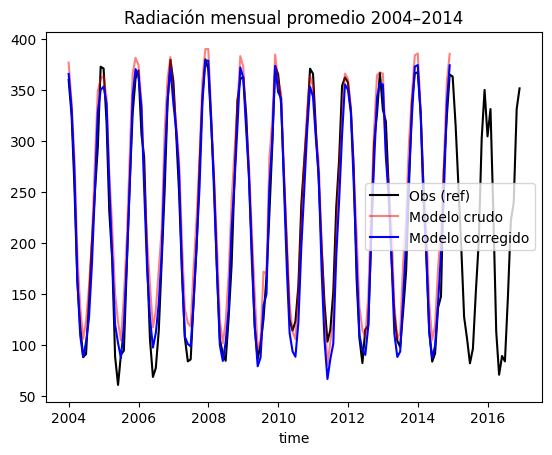

In [60]:

# Ejemplo: ACCESS-CM2 histórico corregido vs obs
hist_bc = apply_factors(hist, F)  # ya lo tenías
ref_mean = ref_mon.mean(("lat","lon"))
hist_mean = hist.mean(("lat","lon"))
hist_bc_mean = hist_bc.mean(("lat","lon"))

plt.figure()
ref_mean.plot(label="Obs (ref)", color="black")
hist_mean.plot(label="Modelo crudo", color="red", alpha=0.5)
hist_bc_mean.plot(label="Modelo corregido", color="blue")
plt.legend()
plt.title("Radiación mensual promedio 2004–2014")
plt.show()


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


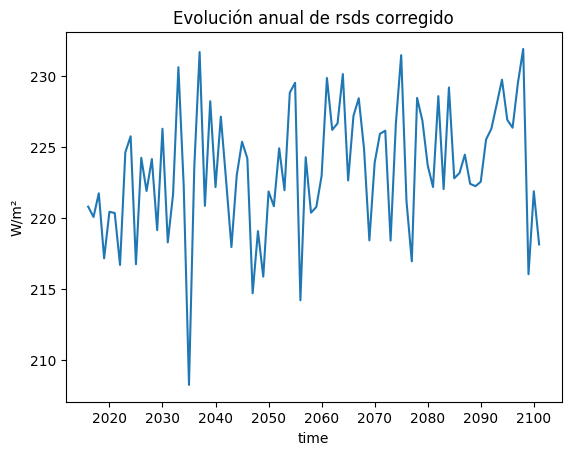

In [61]:
ssp245_bc = xr.open_dataarray("/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_access_cm2_ssp245.nc")

# promedio espacial
ssp245_mean = ssp245_bc.mean(("lat","lon"))

# promedio anual
ssp245_annual = ssp245_mean.resample(time="Y").mean()

ssp245_annual.plot(label="ACCESS-CM2 SSP245")
plt.title("Evolución anual de rsds corregido")
plt.ylabel("W/m²")
plt.show()


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


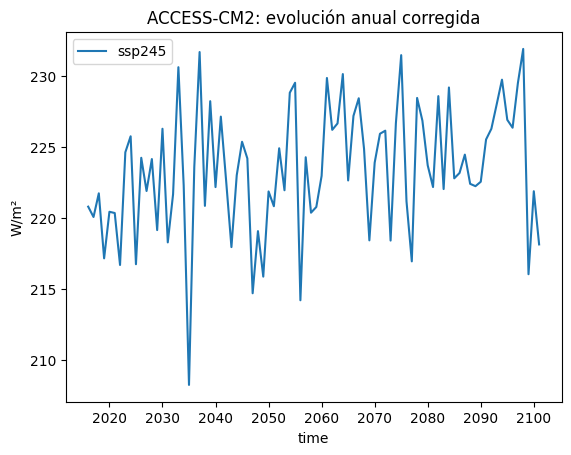

In [ ]:
for ssp in ["ssp245","ssp370","ssp585"]:
    da = xr.open_dataarray(f"/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_access_cm2_{ssp}.nc")
    da.mean(("lat","lon")).resample(time="Y").mean().plot(label=ssp)

plt.legend()
plt.title("ACCESS-CM2: evolución anual corregida")
plt.ylabel("W/m²")
plt.show()


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


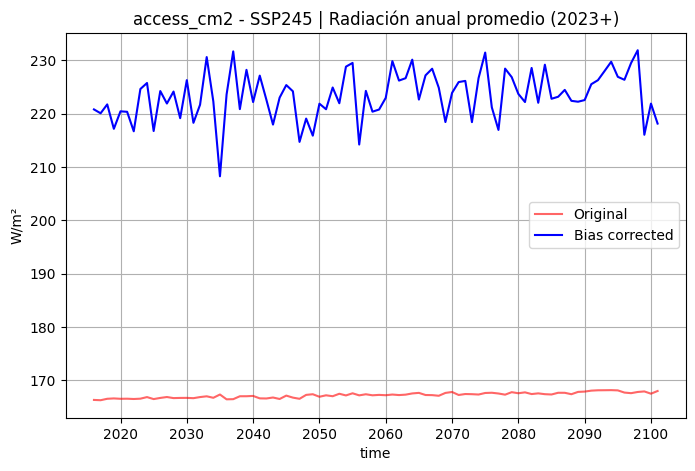

In [64]:
import xarray as xr
import matplotlib.pyplot as plt

model = "access_cm2"
ssp = "ssp245"

# Ruta a tus archivos corregidos y originales
orig_path = f"/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/{ssp}/{model.lower()}/*.nc"
bc_path   = f"/home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected/rsds_bc_Amon_{model}_{ssp}.nc"

# Abrir original (modelo crudo)
orig = xr.open_mfdataset(orig_path, combine="by_coords")["rsds"]

# Abrir bias-corrected
bc = xr.open_dataarray(bc_path)

# Recortar desde 2023 en adelante
orig = orig.sel(time=slice("2015-01-01", None)).mean(("lat","lon"))
bc   = bc.sel(time=slice("2015-01-01", None)).mean(("lat","lon"))

# Pasar a promedios anuales
orig_annual = orig.resample(time="Y").mean()
bc_annual   = bc.resample(time="Y").mean()

# Graficar
plt.figure(figsize=(8,5))
orig_annual.plot(label="Original", color="red", alpha=0.6)
bc_annual.plot(label="Bias corrected", color="blue")
plt.title(f"{model} - {ssp.upper()} | Radiación anual promedio (2023+)")
plt.ylabel("W/m²")
plt.legend()
plt.grid(True)
plt.show()


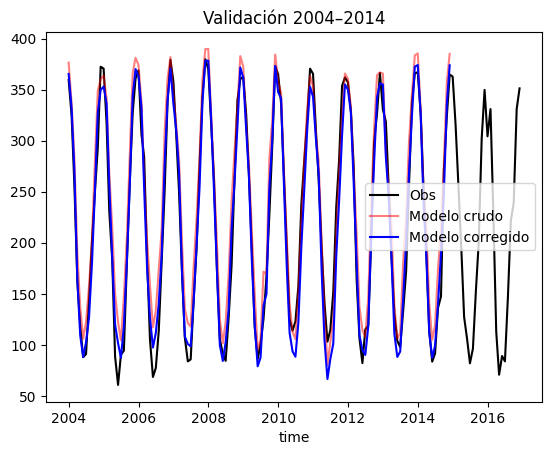

In [66]:
hist_bc = apply_factors(hist, F)
plt.figure()
ref_mon.mean(("lat","lon")).plot(label="Obs", color="black")
hist.mean(("lat","lon")).plot(label="Modelo crudo", color="red", alpha=0.5)
hist_bc.mean(("lat","lon")).plot(label="Modelo corregido", color="blue")
plt.legend()
plt.title("Validación 2004–2014")
plt.show()
